## ***NFL - BIG DATA BOWL***

#### guidelines:

You must use features known at the time when the ball is handed off (TimeHandoff) to forecast the yardage gained on that play (PlayId).

#### goal:
In this competition you will predict how many yards a team will gain on a rushing play in an NFL regular season game. You will loop through a series of rushing plays; for each play, you'll receive the position, velocity, orientation, and more for all 22 players on the field at the moment of handing the ball off to the rusher, along with many other features such as teams, stadium, weather conditions, etc. You'll use this information to predict how many yards the team will gain on the play as a cumulative probability distribution. Once you make that prediction, you can move on to the next rushing play.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy

#we need to use the follwing nflrush
# from kaggle.competitions import nflrush


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## import keras
## import tensorflow as tf

In [3]:
train = pd.read_csv('train.csv', low_memory = False)
train.shape

(509762, 49)

In [6]:
# check variables with their types (int, object, etc)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 49 columns):
GameId                    509762 non-null int64
PlayId                    509762 non-null int64
Team                      509762 non-null object
X                         509762 non-null float64
Y                         509762 non-null float64
S                         509762 non-null float64
A                         509762 non-null float64
Dis                       509762 non-null float64
Orientation               509744 non-null float64
Dir                       509748 non-null float64
NflId                     509762 non-null int64
DisplayName               509762 non-null object
JerseyNumber              509762 non-null int64
Season                    509762 non-null int64
YardLine                  509762 non-null int64
Quarter                   509762 non-null int64
GameClock                 509762 non-null object
PossessionTeam            509762 non-null object
Down   

### Variables meaning:

- GameId - a unique game identifier
- PlayId - a unique play identifier
- Team - home or away
- X - player position along the long axis of the field. See figure below.
- Y - player position along the short axis of the field. See figure below.
- S - speed in yards/second
- A - acceleration in yards/second^2
- Dis - distance traveled from prior time point, in yards
- Orientation - orientation of player (deg)
- Dir - angle of player motion (deg)
- NflId - a unique identifier of the player
- Season - year of the season
- YardLine - the yard line of the line of scrimmage
- Quarter - game quarter (1-5, 5 == overtime)
- GameClock - time on the game clock
- PossessionTeam - team with possession
- Down - the down (1-2-3-4)
- Distance - yards needed for a first down
- FieldPosition - which side of the field the play is happening on
- HomeScoreBeforePlay - home team score before play started
- VisitorScoreBeforePlay - visitor team score before play started
- NflIdRusher - the NflId of the rushing player (importante!)
- OffenseFormation - offense formation
- OffensePersonnel - offensive team positional grouping
- DefendersInTheBox - number of defenders lined up near the line of scrimmage, spanning the width of the offensive line
- DefensePersonnel - defensive team positional grouping
- PlayDirection - direction the play is headed (left/right)
- TimeHandoff - UTC time of the handoff
- TimeSnap - UTC time of the snap
- Yards - the yardage gained on the play (you are predicting this/TARGET VAR)
- Week - week into the season
- StadiumType - description of the stadium environment
- Turf - description of the field surface
- GameWeather - description of the game weather
- Temperature - temperature (deg F)
- Humidity - humidity
- WindSpeed - wind speed in miles/hour
- WindDirection - wind direction

In [48]:
pd.set_option('display.max_columns', None) #in order to display all the var/columns
train.head(10)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
5,2017090700,20170907000118,away,75.06,24.00,1.01,0.32,0.18,308.34,95.01,2543494,Dee Ford,55,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-2,252,03/19/1991,Auburn,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
6,2017090700,20170907000118,away,74.11,16.64,1.11,0.83,0.02,357.23,322.59,2543637,Terrance Mitchell,39,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,5-11,190,05/17/1992,Oregon,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
7,2017090700,20170907000118,away,73.37,18.73,1.24,0.74,0.13,328.52,270.04,2543851,Phillip Gaines,23,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,193,04/04/1991,Rice,CB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
8,2017090700,20170907000118,away,56.63,26.90,0.26,1.86,0.28,344.70,55.31,2550257,Daniel Sorensen,49,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-2,208,03/05/1990,Brigham Young,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
9,2017090700,20170907000118,away,73.35,38.83,4.55,0.76,0.51,75.47,190.84,2552488,Marcus Peters,22,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB

In [14]:
# vedere quante diverse tipologia di forazioni off si posson avere (sicuramente possiam fare encoding dopo)
train.OffenseFormation.value_counts(ascending=True)

ACE               22
EMPTY            506
WILDCAT         1782
JUMBO          11462
PISTOL         13420
I_FORM        106062
SHOTGUN       150964
SINGLEBACK    225434
Name: OffenseFormation, dtype: int64

In [24]:
## crearsi un sub-dataset in cui ci teniam solo le rows (players) oer le quali NflId è uguale alla NflIdRusher
# ovvero quello che "rusha" in attacco la palla (porta avanti l'azione di attacco con una corsa, per semplificarla)
train.loc[train.NflId==2543773]  #check per vedere il rusher (in qst caso White è il runningback dei patriots)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
18,2017090700,20170907000118,home,78.75,30.53,3.63,3.35,0.38,161.98,245.74,2543773,James White,28,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,5-10,205,02/03/1992,Wisconsin,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
40,2017090700,20170907000139,home,71.07,27.16,3.06,2.41,0.34,210.70,312.20,2543773,James White,28,2017,43,1,13:52:00,NE,1,10,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:27.000Z,2017-09-08T00:44:26.000Z,3,5-10,205,02/03/1992,Wisconsin,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
62,2017090700,20170907000189,home,48.66,19.11,5.77,2.42,0.60,140.82,221.96,2543773,James White,28,2017,35,1,13:02:00,NE,1,10,KC,0,0,2543773,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:45:17.000Z,2017-09-08T00:45:15.000Z,5,5-10,205,02/03/1992,Wisconsin,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
128,2017090700,20170907000473,home,42.88,22.73,3.32,2.76,0.44,189.77,319.67,2543773,James White,28,2017,29,1,11:21:00,NE,3,7,KC,7,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",5.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:55:46.000Z,2017-09-08T00:55:45.000Z,10,5-10,205,02/03/1992,Wisconsin,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
304,2017090700,20170907001156,home,29.07,19.68,5.47,4.15,0.58,148.12,193.99,2543773,James White,28,2017,12,1,00:37:00,NE,2,5,KC,7,7,2543773,SINGLEBACK,"1 RB, 1 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",left,2017-09-08T01:22:32.000Z,2017-09-08T01:22:31.000Z,4,5-10,205,02/03/1992,Wisconsin,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
326,2017090700,20170907001177,home,21.94,22.71,2.39,1.68,0.31,180.20,292.46,2543773,James White,28,2017,8,1,00:23:00,NE,3,1,KC,7,7,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 3 LB, 5 DB",left,2017-09-08T01:22:53.000Z,2017-09-08T01:22:52.000Z,0,5-10,205,02/03/1992,Wisconsin,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
853,2017090700,20170907003444,home,87.49,33.96,5.29,2.46,0.55,321.17,45.67,2543773,James White,28,2017,18,3,02:31:00,NE,1,10,KC,24,21,2543773,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,"2 DL, 3 LB, 6 DB",right,2017-09-08T03:15:51.000Z,2017-09-08T03:15:49.000Z,7,5-10,205,02/03/1992,Wisconsin,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
875,2017090700,20170907003465,home,94.67,29.10,3.82,1.88,0.44,10.03,86.23,2543773,James White,28,2017,11,3,02:00:00,NE,2,3,KC,24,21,2543773,SINGLEBACK,"1 RB, 1 TE, 3 WR",7.0,"2 DL, 3 LB, 6 DB",right,2017-09-08T03:16:20.000Z,2017-09-08T03:16:19.000Z,4,5-10,205,02/03/1992,Wisconsin,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
898,2017090700,20170907003507,home,98.58,34.85,5.86,3.24,0.58,319.89,10.86,2543773,James White,28,2017,4,3,00:57:00,NE,2,4,KC,24,21,2543773,SINGLEBACK,"1 RB, 1 TE, 3 WR",8.0,"3 DL, 3 LB, 5 DB",right,2017-09-08T03:17:30.000Z,2017-09-08T03:17:28.000Z,-6,5-10,205,02/03/1992,Wisconsin,RB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
20510,2017091705,20170917050228,away,61.40,28.76,3.16,3.18,0.55,30.43,149.29,2543773,James White,28,2017,42,1,11:36:00,NE,2,8,

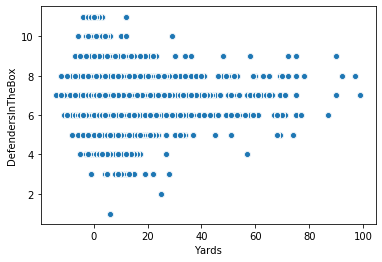

In [26]:
sns.scatterplot(x='Yards', y='DefendersInTheBox', data=train)

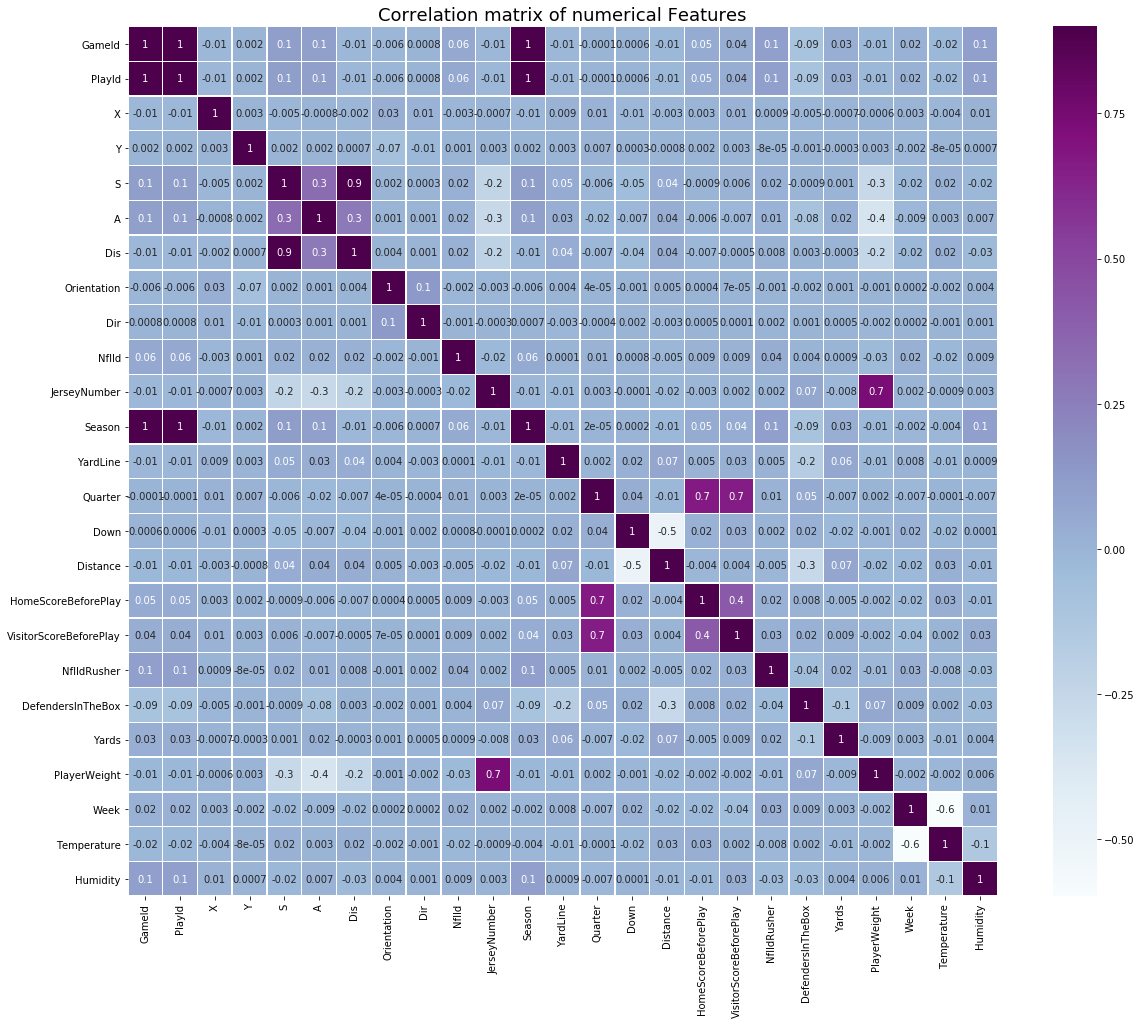

In [41]:
#Exploring correlation between (numerical )features - Looking for relationships based on "Yards" (nostra var target)
cor_mat = train.corr()
f, ax = plt.subplots(figsize=(20, 16))
plt.title('Correlation matrix of numerical Features', size =18)
sns.heatmap(cor_mat, vmax=.9, square=True, linewidths=.4 ,annot=True, cmap ='BuPu', fmt='.1g', annot_kws={'size':10});

In [42]:
# 'Yards' variable
train.Yards.describe()

count    509762.000000
mean          4.212334
std           6.436167
min         -14.000000
25%           1.000000
50%           3.000000
75%           6.000000
max          99.000000
Name: Yards, dtype: float64

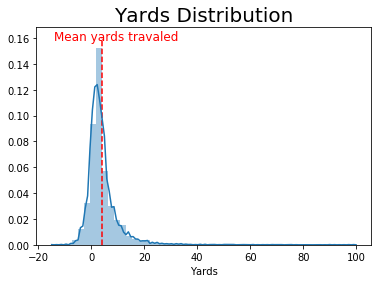

In [47]:
# Distribution plot (per Yards)
ax = sns.distplot(train['Yards'])
plt.vlines(train['Yards'].mean(), plt.ylim()[0], plt.ylim()[1], color='r', linestyles='--'); #vert line added (red)
plt.text(train['Yards'].mean()-18, plt.ylim()[1]-0.010, "Mean yards travaled", size=12, color='r') #add sub-title (mean yards in red)
plt.xlabel("Yards")
plt.title("Yards Distribution", size=20);